In [116]:
import sys
sys.path.append('../')
import joblib

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim
from Modules.Models.BuildBINNs import chi
from Modules.Utils.ModelWrapper import ModelWrapper

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from scipy.integrate import solve_ivp 

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, plot_loss_convergence

In [117]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [118]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

# data parameters
population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 3
multiple = True
parallelb = True
n_runs = 2048
chi_type = 'piecewise'

# model parameters
maskb = True
masking_learned = False

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [119]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [120]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['population'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [121]:
if masking > 0 and masking_learned == True:
    all_data = np.concatenate([data, avg_masking[:,None]], axis=1)
    sparse_coef_path = path + 'mt_eq_coef/'
    if multiple:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_' + str(n_runs) + '_sparse_coef_54comps')
    else:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_sparse_coef_54comps')
    params['mask_coef'] = np.append(np.array(ml_dict['Lasso'].intercept_), ml_dict['Lasso'].coef_)
else:
    all_data = data

In [122]:
model_path = '../models/covasim'
if maskb:
    model_path += '/mask'
    if masking_learned:
        model_path += '/learned_masking'
    else:
        model_path += '/observed_masking'
else:
    model_path += '/no_mask'

In [123]:
#--------------------no masking----------------------#
# model_folder = '/2023-07-20_17-53-03' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 800e3 epochs, lr=1e-5
# model_folder = '/2023-07-21_18-42-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=1e-6
# model_folder = '/2023-07-22_10-20-01' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=5e-6
# model_folder = '/2023-07-23_00-48-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=9e-6
# model_folder = '/2023-07-23_15-17-23' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=9e-6
# model_folder = '/2023-07-24_23-10-16' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=9e-6

#------------------normal masking--------------------#
# model_folder = '/2023-07-20_18-13-01' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_18-41-30' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_21-48-16' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_10-16-47' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_12-30-47' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-23_00-01-28' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-23_00-27-07' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-23_15-14-54' # masking-norm, observed M, 1e6, dynamic piecewise, 64 avg., 800e3, lr=4e-5
model_folder = '/2023-07-27_22-37-14' # masking-norm, observed M, 1e6, dynamic piecewise, 2048 avg., 800e3, lr=4e-5

#---------------demographic masking------------------#
# model_folder = '/2023-07-20_22-20-10' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=5e-5
# model_folder = '/2023-07-23_15-15-56' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=5e-5
# model_folder = '/2023-07-24_23-09-21' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=3e-6
# model_folder = '/2023-07-24_23-09-34' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=3e-6
# model_folder = '/2023-07-25_20-44-25' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 700e3, lr=4e-6

mydir = model_path + model_folder

In [124]:
# mydir = '../models/covasim/mask/2023-07-13_23-46-11' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 200,000 epochs, lr=1e-4
# mydir = '../models/covasim/mask/2023-07-16_16-48-08' # norm masking, 500e3 pop, dynamic piecewise, keepd, 2048 avg., 800,000 epochs, lr=5e-5
# mydir = '../models/covasim/no_mask/2023-07-18_18-53-36' # no masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 500,000 epochs, lr=5e-5
# mydir = '../models/covasim/mask/2023-07-19_22-22-04' # norm masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 600,000 epochs, lr=5e-5
# mydir = '../models/covasim/mask/2023-07-19_22-21-24' # dem masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 600,000 epochs, lr=5e-5
# mydir = '../models/covasim/no_mask/2023-07-19_22-21-50' # no masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 700,000 epochs, lr=1e-5

In [125]:
# instantiate BINN model
yita_lb = 0.0
yita_ub = 1.0
beta_lb = 0.0
beta_ub = 0.5
tau_lb = 0.1
tau_ub = 0.3
eta_deep = True
beta_deep = True
tau_deep = False

binn = AdaMaskBINNCovasim(params, 
                t_max_real=t_max, 
                tracing_array=tracing_array, 
                yita_lb=None, 
                yita_ub=None,
                beta_lb=None,
                beta_ub=None,
                tau_lb=tau_lb,
                tau_ub=tau_ub, 
                chi_type=chi_type,
                eta_deep=eta_deep,
                beta_deep=beta_deep,
                tau_deep=tau_deep,
                maskb=maskb,
                masking_learned=masking_learned).to(device)

parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [126]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

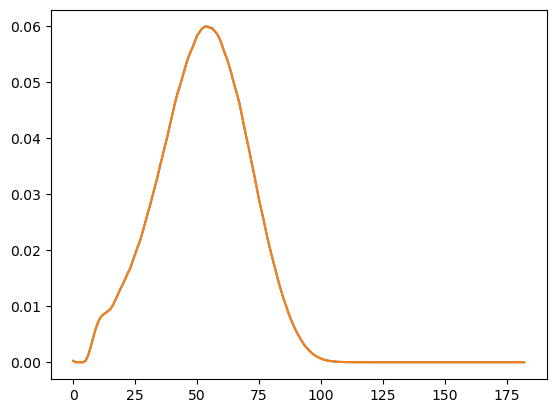

In [127]:
if not masking_learned and maskb:
    # B-spline
    best_val_score = -1
    max_degree = 12
    for i in range(2, t.shape[0] // 2):
        for j in range(1, max_degree + 1):
            interp = make_pipeline(SplineTransformer(i, degree=j), Ridge(alpha=1e-6))
            interp.fit(t, avg_masking)
            if interp.score(t, avg_masking) > best_val_score:
                best_interp = interp
                best_val_score = best_interp.score(t, avg_masking)
            
            
    plt.plot(t, avg_masking)
    plt.plot(t, best_interp.predict(t))
    t_interp = np.linspace(0, 183, num=1000).reshape(-1, 1)
    avg_masking_interp = best_interp.predict(t_interp)

In [128]:
# learned surface fitter
def surface_fitter(t):
    res = binn.surface_fitter(to_torch(t))
    return res

# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u))
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

def chi_func(t):
    chi_t = chi(1 + to_torch(t) * t_max, trace_prob, chi_type)
    return chi_t

In [129]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [130]:
# if D is to be included in the model, otherwise use the other solver.
if maskb:
    if not masking_learned:
        params['avg_masking'] = avg_masking_interp
    else:
        params['avg_masking'] = surface_fitter(t)[:,9].detach().numpy()

In [131]:
if keep_d:
    RHS = PDESolver.STEAYDQRF_RHS_dynamic_DRUMS
    u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, 
                                        u0, 
                                        t, 
                                        contact_rate, 
                                        beta, 
                                        tau, 
                                        params, 
                                        chi_type, 
                                        masking=maskb)
    
    u_sim_NN *= population

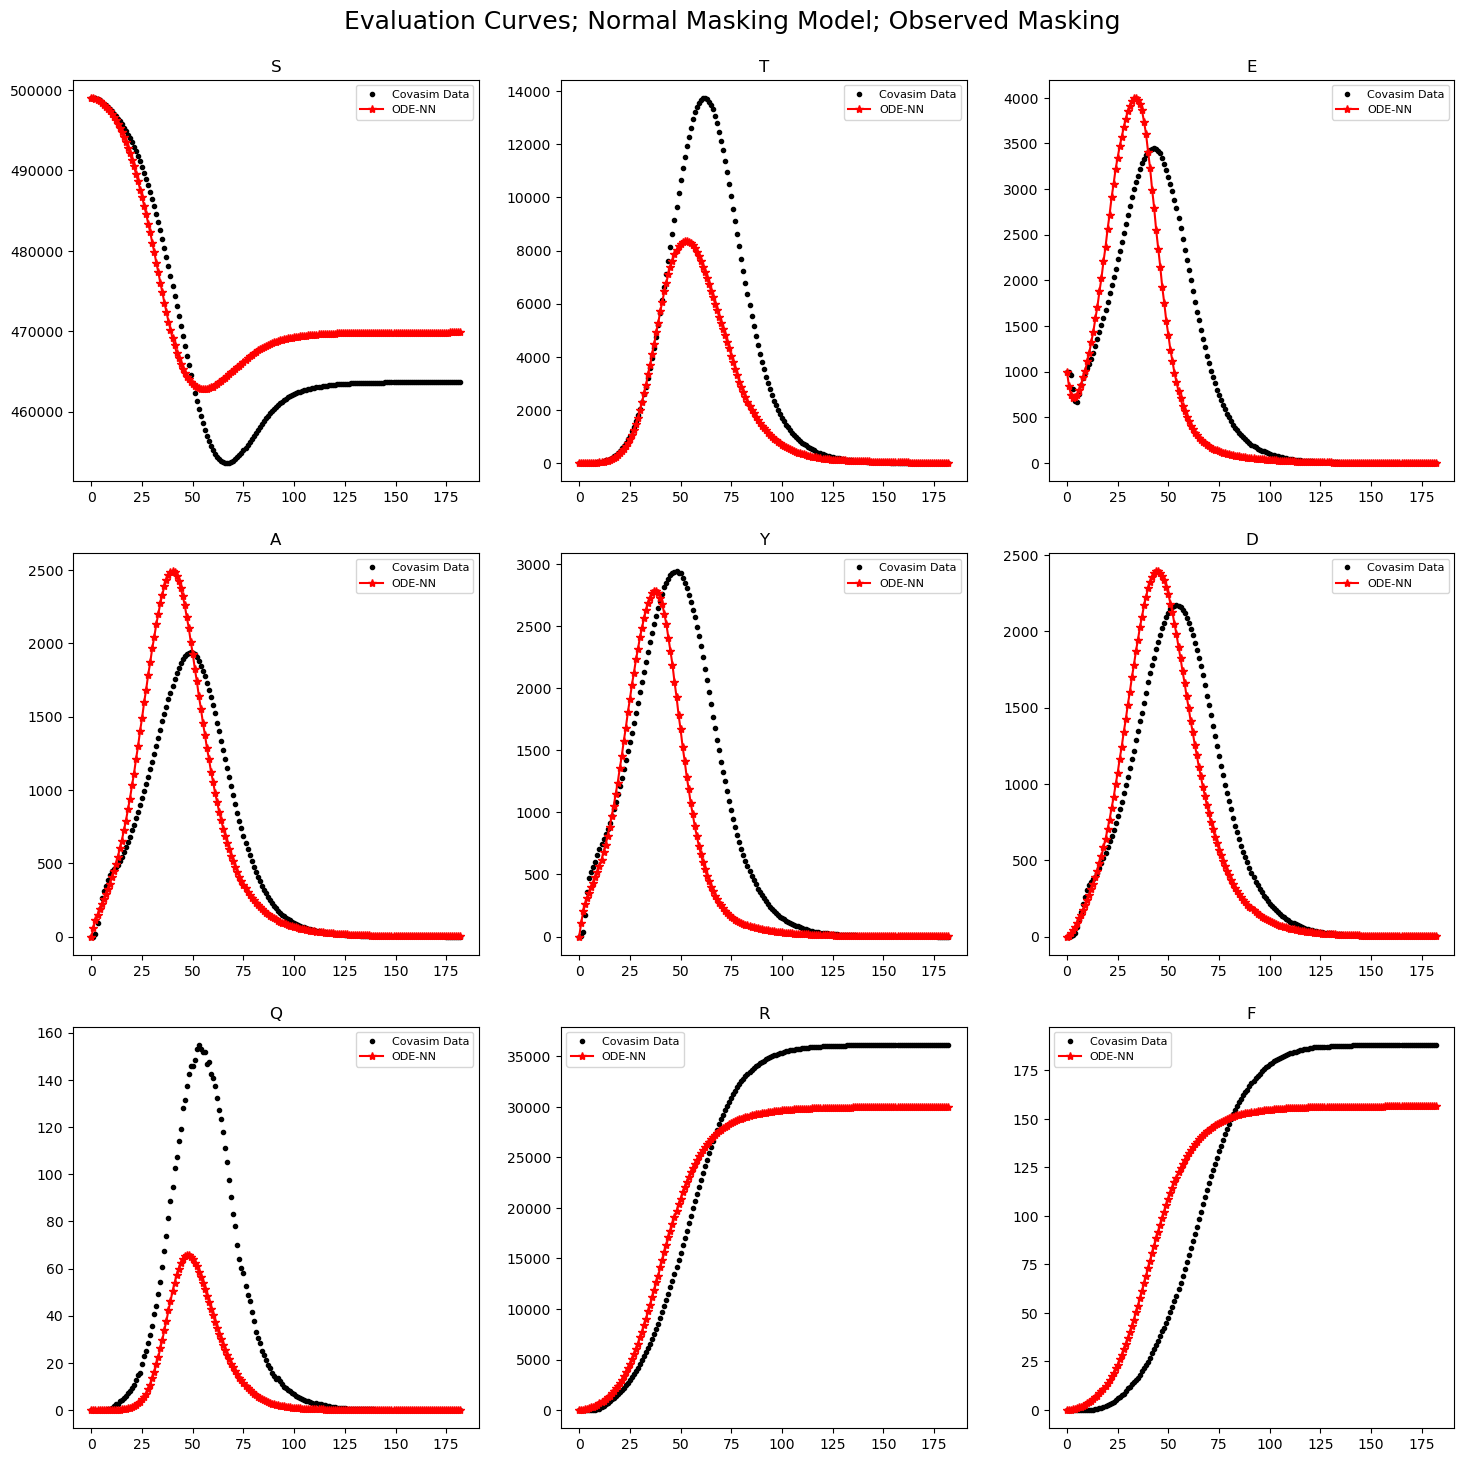

In [132]:
# rescale data values to represent number of people in state X rather than ratios
scaled_data = data * population

if masking > 0:
    if masking == 1:
        suptitle_name = 'Evaluation Curves; Demographic Masking Model; Observed Masking'
    elif masking == 3:
        suptitle_name = 'Evaluation Curves; Normal Masking Model; Observed Masking'
else:
    suptitle_name = 'Evaluation Curves; No Masking Model; No Masking'

plot=True
if plot:
    n = scaled_data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(suptitle_name, size=18)
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, scaled_data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        # plt.savefig(os.path.join(model.save_folder, case_name + '.png'), dpi=400)
        # plt.show()

### Evaluation with LASSO estimates of learned parameters

In [133]:
# load the LASSO dictionaries for each parameter with the specifc number of nonzero component coefficients
eta_ld = joblib.load(model.save_folder + '/eta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_best')
beta_ld = joblib.load(model.save_folder + '/beta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_best')
tau_ld = joblib.load(model.save_folder + '/tau_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_best')

eta_rhs = eta_ld['Equation'][4:]
beta_rhs = beta_ld['Equation'][4:]
tau_rhs = tau_ld['Equation'][4:]

eta_coef = np.append(eta_ld['Lasso'].intercept_, eta_ld['Lasso'].coef_)
beta_coef = np.append(beta_ld['Lasso'].intercept_, beta_ld['Lasso'].coef_)
tau_coef = np.append(tau_ld['Lasso'].intercept_, tau_ld['Lasso'].coef_)

# define the degree of the features
eta_degree = eta_ld['degree']
beta_degree = beta_ld['degree']
tau_degree = tau_ld['degree']

# specify if the parameters are linear combinations of inputs are all compartments in the model
eta_all_comps = False
beta_all_comps = False
tau_all_comps = False

print(f"eta = {eta_rhs}")
print(np.round(eta_ld['MSE'], 10))
print(f"beta = {beta_rhs}")
print(np.round(beta_ld['MSE'], 10))
print(f"tau = {tau_rhs}")
print(np.round(tau_ld['MSE'], 10))

eta = 1.45485*S + 98.99333*A + 1.20158*M + 0.32821*S^2 + -23.32296*S Y + 0.49780*S M + -7.28284*M^2 + 0.41336*S^3 + -28.78403*S^2 Y + 1.19571*S^2 M + 0.37658*S^4 + -44.27253*S^3 Y + 1.88553*S^3 M + -2.20664
9.24536e-05
beta = 0.29926*s + -0.08587*s^2 + 0.23040*s x + -0.00308
3.921e-07
tau = 0.10000
0.0


c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LassoCV from version 1.3.0 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [134]:
eta_features = []
eta_rhs_split = eta_rhs.split('*')
for i, elem in enumerate(eta_rhs_split):
    if i == 0:
        continue
    else:
        sl = elem.split(' +')
        eta_features.append(sl[0])
        
beta_features = []
beta_rhs_split = beta_rhs.split('*')
for i, elem in enumerate(beta_rhs_split):
    if i == 0:
        continue
    else:
        sl = elem.split(' +')
        beta_features.append(sl[0])
        
tau_features = []
tau_rhs_split = tau_rhs.split('*')
for i, elem in enumerate(tau_rhs_split):
    if i == 0:
        continue
    else:
        sl = elem.split(' +')
        tau_features.append(sl[0])

eta_vec = '1'
for elem in eta_features:
    eta_vec += ' & ' + elem 

beta_vec = '1'
for elem in beta_features:
    if 's' in elem:
        elem = elem.replace('s', '(S+A+Y)')
    if 'x' in elem:
        elem = elem.replace('x', '\chi')
    beta_vec += ' & ' + elem

tau_vec = '1'
for elem in tau_features:
    tau_vec += ' & ' + elem

print(eta_vec)
print(beta_vec)
print(tau_vec)

1 & S & A & M & S^2 & S Y & S M & M^2 & S^3 & S^2 Y & S^2 M & S^4 & S^3 Y & S^3 M
1 & (S+A+Y) & (S+A+Y)^2 & (S+A+Y) \chi
1


In [135]:
# learned contact_rate function
def eta_lasso(u):
    res = np.matmul(u, eta_coef)
    return res[:,None]

# learned effective tracing rate function
def beta_lasso(u):
    res = np.matmul(u, beta_coef)
    return res[:,None]

# learned diagnosis of quarantined rate function
def tau_lasso(u):
    res = np.matmul(u, tau_coef)
    return res[:,None]

In [136]:
# if D is to be included in the model, otherwise use the other solver.
if masking > 0:
    params['avg_masking'] = avg_masking_interp
if keep_d:
    RHS = PDESolver.STEAYDQRF_RHS_dynamic_DRUMS
    reg_sim_NN = PDESolver.STEAYDQRF_sim(RHS, 
                                            u0, 
                                            t, 
                                            eta_lasso, 
                                            beta_lasso, 
                                            tau_lasso, 
                                            params, 
                                            chi_type, 
                                            masking=maskb, 
                                            eta_all_comps=eta_all_comps,
                                            beta_all_comps=beta_all_comps,
                                            tau_all_comps=tau_all_comps,
                                            eta_degree=eta_degree,
                                            beta_degree=beta_degree,
                                            tau_degree=tau_degree)
    
    reg_sim_NN *= population

In [137]:
eval_name = '_regression.png'
if eta_all_comps:
    eval_name = '_eta_allcomps' + eval_name
if beta_all_comps:
    eval_name = '_beta_allcomps' + eval_name
if tau_all_comps:
    eval_name = '_tau_allcomps' + eval_name

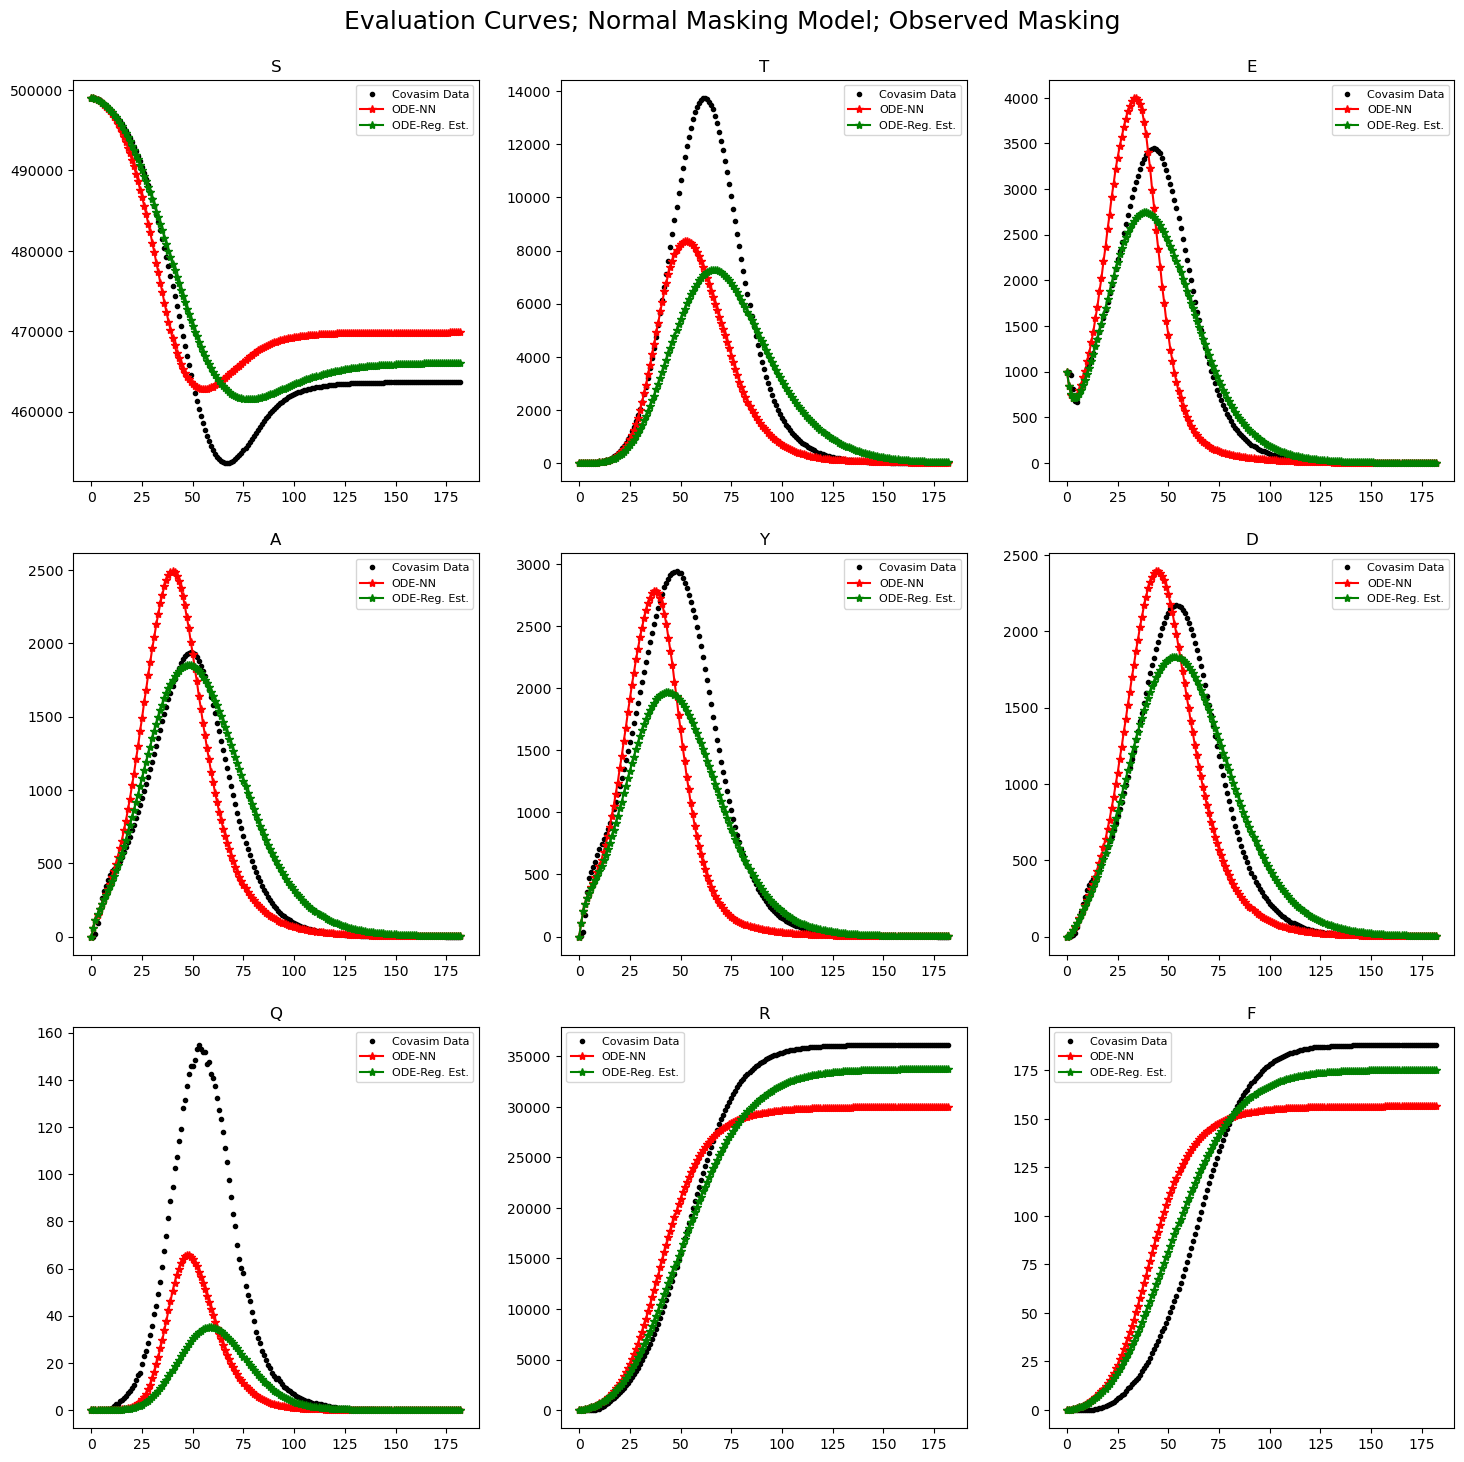

In [138]:
# rescale data values to represent number of people in state X rather than ratios
scaled_data = data * population

if masking > 0:
    if masking == 1:
        suptitle_name = 'Evaluation Curves; Demographic Masking Model; Observed Masking'
    elif masking == 3:
        suptitle_name = 'Evaluation Curves; Normal Masking Model; Observed Masking'
else:
    suptitle_name = 'Evaluation Curves; No Masking Model; No Masking'

plot=True
if plot:
    n = scaled_data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(suptitle_name, size=18)
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, scaled_data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.plot(t, reg_sim_NN[:, i - 1], '-*g', label='ODE-Reg. Est.')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        # plt.savefig(os.path.join(model.save_folder, case_name + eval_name), dpi=400)
        # plt.show()

In [146]:
y0comp = np.array(u0, dtype = "complex")

lasso_tup = (eta_ld["Lasso"], beta_ld["Lasso"], tau_ld["Lasso"])

sens_list = []
h = 1e-16
comp = 1e-16j #the complex number with 0 real and 1e-16 complex part

# To Do: What are the object types of .coef_????
# To Do: Make sure we are including the constant from Lassoing the MLPs (BIG DEAL!)
macro_coefs = [np.concatenate((macro_param.coef_, np.array([macro_param.intercept_]))) for macro_param in lasso_tup]

time_span = (t[0], t_max)

In [160]:
RHS = PDESolver.STEAYDQRF_RHS_dynamic_DRUMS

macro_coefs_copy = macro_coefs.copy()
for i, param_coefs in enumerate(macro_coefs): #iterates through the list of arrays, macro_coefs
    macro_coefs_copy[i] = np.array(macro_coefs[i], dtype = "complex")
    for coef_idx, coef in enumerate(param_coefs): #iterates through the array of coefficients, param_coefs
        if coef != 0:
            macro_coefs_copy[i][coef_idx] += comp
            coefs_tup = tuple(macro_coefs_copy)
            comp_args = (coefs_tup, params, t_max, chi_type)
            sol2 = PDESolver.STEAYDQRF_sim(RHS, 
                                            y0comp, 
                                            t, 
                                            eta_lasso, 
                                            beta_lasso, 
                                            tau_lasso, 
                                            params, 
                                            chi_type, 
                                            masking=maskb, 
                                            eta_all_comps=eta_all_comps,
                                            beta_all_comps=beta_all_comps,
                                            tau_all_comps=tau_all_comps,
                                            eta_degree=eta_degree,
                                            beta_degree=beta_degree,
                                            tau_degree=tau_degree)
            print(sol2)
            sol2_mat = np.matrix(sol2).T
            sens_vals = np.imag(sol2_mat/h)
            sens_list.append(sens_vals)

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


[[9.98000000e-01 0.00000000e+00 2.00000000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97931122e-01 9.96270636e-09 1.69803885e-03 ... 2.78262708e-12
  1.68286802e-05 8.67159507e-08]
 [9.97740075e-01 1.94994565e-07 1.50274658e-03 ... 1.02604839e-10
  7.42313262e-05 3.82468881e-07]
 ...
 [9.32097707e-01 6.07431285e-05 1.98544903e-06 ... 1.00867519e-09
  6.74768829e-02 3.50492580e-04]
 [9.32101811e-01 5.63077152e-05 1.85097389e-06 ... 8.84730403e-10
  6.74781694e-02 3.50499172e-04]
 [9.32105009e-01 5.28507836e-05 1.74589547e-06 ... 7.93096973e-10
  6.74791746e-02 3.50504322e-04]]


c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  u[0,:] = IC


KeyboardInterrupt: 

In [139]:
def lasso_ODE_test(t, y, tup : tuple, params : dict, t_max, chi_type):
# def lasso_ODE_test(t, y, *args):

    '''
    t (float)           : initial time  **check me, should this be initial time or tuple of time?
    y (list)            : list of initial conditions (floats) for STEAYDQRF
    tup (tuple)         : tuple of lasso objects for eta beta and tau, or tuple of complex coefficients
    params (dict)       : parameters of the Covasim model from the learned MLP
    t_max (float)       : max of time (last day of simulation)  **check me, if time is a tuple, do I need this?
    chi_type
    '''



    population = params['population']
    alpha = params['alpha']
    gamma = params['gamma']
    mu = params['mu']
    lamda = params['lamda']
    p_asymp = params['p_asymp']
    n_contacts = params['n_contacts']
    delta = params['delta']
    eff_ub = params['eff_ub']
    chi = chi_func(t)

    

    # evaluate the constant value of each parameter
    S, T, E, A, Y, D, Q, R, F = tuple(y)   #values at this specific time

    # this is checking to see if we are doing complex or not

    if isinstance(tup[0], LassoCV): #not complex
        eta_lasso, beta_lasso, tau_lasso = tup #tuple of lasso objects

        #_____________________________________________________________________
        #   eta
        eta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        eta_input = eta_poly.fit_transform(np.array([[S, A, Y]]))
        eta_input = eta_input[:,1:]

        #if using predict: 
        #eta_i = eta_lasso.predict(eta_input)    #eta value at this specific time

        #if using dot products instead of predict:
        eta_input = np.squeeze(eta_input)
        eta_co = eta_lasso.coef_
        eta_i = np.dot(eta_input, eta_co) + eta_lasso.intercept_
   
        #_____________________________________________________________________
        #   beta

        beta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        beta_input = beta_poly.fit_transform([[S+A+Y, chi]])
        beta_input = beta_input[:,1:]

        #if using predict: 
        #beta_i = beta_lasso.predict(beta_input)

        #if using dot products instead of predict:
        beta_input = np.squeeze(beta_input)
        beta_co = beta_lasso.coef_
        beta_i = np.dot(beta_input, beta_co) + beta_lasso.intercept_
        #_____________________________________________________________________
        #   tau

        tau_poly = PolynomialFeatures(degree = 2, include_bias = True)
        tau_input = tau_poly.fit_transform([[A, Y]])
        tau_input = tau_input[:,1:]

        #if using predict: 
        #tau_i = tau_lasso.predict(tau_input)

        #if using dot products instead of predict:
        tau_input = np.squeeze(tau_input)
        tau_co = tau_lasso.coef_
        tau_i = np.dot(tau_input, tau_co) + tau_lasso.intercept_

        #__________________________________________________________________

        new_d = mu * Y +  tau_i * Q

        dS = - eta_i * S * (A + Y) -  beta_i * new_d *  n_contacts * S +  alpha * T

        dT = beta_i * new_d *  n_contacts * S -  alpha * T

        dE = eta_i * S * (A + Y) -  gamma * E

        dA =  p_asymp *  gamma * E -  lamda * A -  beta_i * new_d *  n_contacts * A

        dY = (1 -  p_asymp) *  gamma * E - ( mu +  lamda +  delta) * Y -  beta_i * new_d *  n_contacts * Y

        dD =  mu * Y + tau_i * Q - lamda * D - delta * D

        dQ =  beta_i * new_d *  n_contacts * (A + Y) - (tau_i + delta) * Q

        dR =  lamda * (A + Y + D)

        dF =  delta * (Y + D + Q)


        result = [float(dS), float(dT), float(dE), float(dA), float(dY), float(dD), float(dQ), float(dR), float(dF)]
        return result






    else:   #using manual coefficients instead of lasso objects because they're complex
              
        eta_coefs, beta_coefs, tau_coefs = tup
        S = float(S)
        T = float(T)
        E = float(E)
        A = float(A)
        Y = float(Y)
        D = float(D)
        Q = float(Q)
        R = float(R)
        F = float(F)
          
        #_____________________________________________________________________
        #   eta

        eta_poly = PolynomialFeatures(degree = 2, include_bias = True)

        eta_input = eta_poly.fit_transform(np.array([[S, A, Y]]))
        eta_input = eta_input[:,1:]
        #if using predict: 
        #eta_i = eta_lasso.predict(eta_input)    #eta value at this specific time

        #if using dot products instead of predict:
        eta_input = np.squeeze(eta_input)
        eta_co = eta_coefs[:-1]
        eta_i = np.dot(eta_input, eta_co) + eta_coefs[-1]
        eta_i = eta_i + 0j
       

        #_____________________________________________________________________
        #   beta

        beta_poly = PolynomialFeatures(degree = 2, include_bias = True)
        beta_input = beta_poly.fit_transform([[S+A+Y, chi]])
        beta_input = beta_input[:,1:]

        #if using predict: 
        #beta_i = beta_lasso.predict(beta_input)

        #if using dot products instead of predict:
        beta_input = np.squeeze(beta_input)
        beta_co = beta_coefs[:-1]
        beta_i = np.dot(beta_input, beta_co) + beta_coefs[-1]
        beta_i = beta_i + 0j

        #_____________________________________________________________________
        #   tau
        
        tau_poly = PolynomialFeatures(degree = 2, include_bias = True)
        tau_input = tau_poly.fit_transform([[A, Y]])
        tau_input = tau_input[:,1:]

        #if using predict: 
        #tau_i = tau_lasso.predict(tau_input)

        #if using dot products instead of predict:
        tau_input = np.squeeze(tau_input)
        tau_co = tau_coefs[:-1]
        tau_i = np.dot(tau_input, tau_co) + tau_coefs[-1]
        tau_i =tau_i + 0j
        #_____________________________________________________________________
    

        new_d = mu * Y +  tau_i * Q




        dS = - eta_i * S * (A + Y) -  beta_i * new_d *  n_contacts * S +  alpha * T

        dT = beta_i * new_d *  n_contacts * S -  alpha * T

        dE = eta_i * S * (A + Y) -  gamma * E

        dA =  p_asymp *  gamma * E -  lamda * A -  beta_i * new_d *  n_contacts * A

        dY = (1 -  p_asymp) *  gamma * E - ( mu +  lamda +  delta) * Y -  beta_i * new_d *  n_contacts * Y

        dD =  mu * Y + tau_i * Q - lamda * D - delta * D

        dQ =  beta_i * new_d *  n_contacts * (A + Y) - (tau_i + delta) * Q

        dR =  complex(lamda * (A + Y + D), 0)

        dF =  complex(delta * (Y + D + Q), 0)


    
        result = [dS, dT, dE, dA, dY, dD, dQ, dR, dF]
  

        return result

In [140]:
y0comp = np.array(u0, dtype = "complex")

In [141]:
y0comp = np.array(u0, dtype = "complex")

lasso_tup = (eta_ld["Lasso"], beta_ld["Lasso"], tau_ld["Lasso"])

sens_list = []
h = 1e-16
comp = 1e-16j #the complex number with 0 real and 1e-16 complex part

# To Do: What are the object types of .coef_????
# To Do: Make sure we are including the constant from Lassoing the MLPs (BIG DEAL!)
macro_coefs = [np.concatenate((macro_param.coef_, np.array([macro_param.intercept_]))) for macro_param in lasso_tup]

time_span = (t[0], t_max)

In [142]:
macro_coefs_copy = macro_coefs
for i, param_coefs in enumerate(macro_coefs): #iterates through the list of arrays, macro_coefs
    macro_coefs_copy[i] = np.array(macro_coefs[i], dtype = "complex")
    for coef_idx, coef in enumerate(param_coefs): #iterates through the array of coefficients, param_coefs
        if coef != 0:
            macro_coefs_copy[i][coef_idx] += comp
            coefs_tup = tuple(macro_coefs_copy)
            comp_args = (coefs_tup, params, t_max, chi_type)
            sol2 = solve_ivp(lasso_ODE_test, time_span, y0comp, t_eval=time_values, args=comp_args, method='RK45')
            sol2_mat = np.matrix(sol2.y).T
            sens_vals = np.imag(sol2_mat/h)
            sens_list.append(sens_vals)

print(np.max(sens_list[0]))

TypeError: expected np.ndarray (got float)